In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
def to_float(v):
    if(v == "?"):
        return 0
    else:
        return float(v)

def load_trace():
    all_x = []
    all_y = []

    with open("data/ozone/eighthr.data","r") as f:
        miss = 0
        total = 0
        while True:
            line = f.readline()
            if(line is None):
                break
            line = line[:-1]
            parts = line.split(',')

            total+=1
            for i in range(1,len(parts)-1):
                if(parts[i]=="?"):
                    miss+=1
                    break

            if(len(parts)!=74):
                break
            label = int(float(parts[-1]))
            feats = [to_float(parts[i]) for i in range(1,len(parts)-1)]

            all_x.append(np.array(feats))
            all_y.append(label)
    print("Missing features in {} out of {} samples ({:0.2f})".format(miss,total,100*miss/total))
    print("Read {} lines".format(len(all_x)))
    all_x = np.stack(all_x,axis=0)
    all_y = np.array(all_y)

    print("Imbalance: {:0.2f}%".format(100*np.mean(all_y)))
    all_x -= np.mean(all_x) #normalize
    all_x /= np.std(all_x) #normalize

    return all_x,all_y


def cut_in_sequences(x,y,seq_len,inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0,x.shape[0] - seq_len,inc):
        start = s
        end = start+seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x,axis=1),np.stack(sequences_y,axis=1)


seq_len=32

x,y = load_trace()
        
train_x,train_y = cut_in_sequences(x,y,seq_len,inc=4)

train_x = np.stack(train_x,axis=1)
train_y = np.stack(train_y,axis=1)

total_seqs = train_x.shape[1]
print("Total number of training sequences: {}".format(total_seqs))
permutation = np.random.RandomState(23489).permutation(total_seqs)
valid_size = int(0.1*total_seqs)
test_size = int(0.15*total_seqs)

valid_x = train_x[:,permutation[:valid_size]]
valid_y = train_y[:,permutation[:valid_size]]
test_x = train_x[:,permutation[valid_size:valid_size+test_size]]
test_y = train_y[:,permutation[valid_size:valid_size+test_size]]
train_x = train_x[:,permutation[valid_size+test_size:]]
train_y = train_y[:,permutation[valid_size+test_size:]]

Missing features in 687 out of 2535 samples (27.10)
Read 2534 lines
Imbalance: 6.31%
Total number of training sequences: 32


In [12]:
from tensorflow import keras
from kerasncp import wirings
from kerasncp.tf import LTCCell
import matplotlib.pyplot as plt
import seaborn as sns

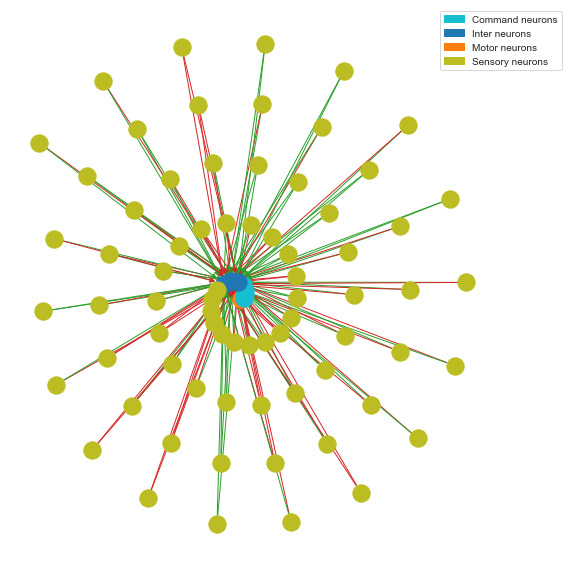

In [6]:
ncp_arch = wirings.NCP(
    inter_neurons=3,  # Number of inter neurons
    command_neurons=4,  # Number of command neurons
    motor_neurons=1,  # Number of motor neurons
    sensory_fanout=2,  # How many outgoing synapses has each sensory neuron
    inter_fanout=2,  # How many outgoing synapses has each inter neuron
    recurrent_command_synapses=3,  # Now many recurrent synapses are in the
    # command neuron layer
    motor_fanin=4,  # How many incomming syanpses has each motor neuron
)
ncp_cell = LTCCell(ncp_arch)

ncp_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 72)),
        keras.layers.RNN(ncp_cell, return_sequences=True),
    ]
)
ncp_model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

sns.set_style("white")
plt.figure(figsize=(8, 8))
legend_handles = ncp_cell.draw_graph(layout='spiral',neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [7]:
hist_ncp = ncp_model.fit(x=train_x, y=train_y, batch_size=1, epochs=200,verbose=0)

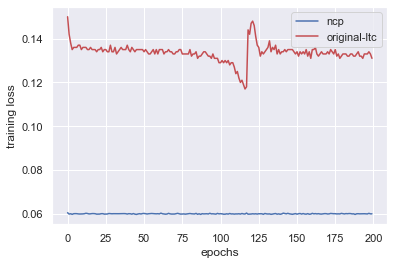

In [10]:
sns.set()
plt.figure(figsize=(6, 4))
plt.plot()
plt.plot(hist_ncp.history["loss"],label='ncp')
data_ltc_gesture = np.loadtxt('ltc_train_loss_ozone.txt')
x_ltc_gesture = data_ltc_gesture[:, 0]
y_ltc_gesture = data_ltc_gesture[:, 1]
plt.plot(x_ltc_gesture, y_ltc_gesture,'r',label="original-ltc")
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.legend(loc="upper right")
plt.show()

In [14]:
# To compute sparsity
fc_wiring = wirings.FullyConnected(8, 1)  # 8 units, 1 of which is a motor neuron
ltc_cell = LTCCell(fc_wiring)

model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 72)),
        keras.layers.RNN(ltc_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  (None, None, 1)           2730      
Total params: 2,730
Trainable params: 2,730
Non-trainable params: 0
_________________________________________________________________


In [15]:
sparsity = 1 - ncp_cell.synapse_count /ltc_cell.synapse_count
print("Sparsity level is {:0.2f}%".format(100*sparsity))

Sparsity level is 78.12%


In [17]:
ncp_model.evaluate(valid_x,valid_y)

20/20 [==============================] - 0s 3ms/step - loss: 0.0626


0.06262126564979553